In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def Triangle_Threshold(img):
    # the input image should be in gray scale
    (y, x) = np.shape(img)
    # do the image structure analysis, which is the distribution of pixels according to grayscale value
    num_px = np.zeros(256)
    for row in range(x):
        for col in range(y):
            pixel_value = img[col][row]
            num_px[pixel_value] += 1

    # calculate the cumulative distribution function
    opti = np.arange(1, 256, 1)
    H = np.zeros(opti.shape)
    for i in range(len(opti)):
        H[i] = np.sum(num_px[1:opti[i]]) / np.sum(num_px[:])

    # calculate H'(x)
    dH = np.zeros(H.shape[0])
    for i in range(len(dH) - 1):
        dH[i] = H[i + 1] - H[i]

    # do the triangle thresholding according to Bakhoday-Paskyabi et al. 2016
    dH_max = max(dH[1:250])
    bmax = int(np.argwhere(dH[1:250] == dH_max)[-1])
    if np.argwhere(H == 1).any():
        binflec = int(
            min(np.argwhere(H == 1))
        )  # the first point where the normalized cumulative function comes 1
        if binflec >= 254:
            binflec = 250
    else:
        binflec = 250
    dH_inflec = dH[binflec]

    A = dH_inflec - dH_max
    B = bmax - binflec
    C = (dH_max - dH_inflec) * bmax + (binflec - bmax) * dH_max
    if (binflec - bmax + 1) > 0:
        distance = np.zeros(binflec - bmax + 1)
        for i in range(bmax, binflec + 1):
            distance[i - bmax] = np.abs(A * i + B * dH[i] +
                                        C) / (np.sqrt(A**2 + B**2) + 1e-6)
        threshold = np.argwhere(
            distance == max(distance)
        )[-1] + bmax  # take the last one which has the maximum distance
    else:
        threshold = 255
    return threshold

In [3]:
def unevenLightCompensate(img, blockSize):
    # this function is used to even the light distribution in one image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average = np.mean(gray)

    rows_new = int(np.ceil(gray.shape[0] / blockSize))
    cols_new = int(np.ceil(gray.shape[1] / blockSize))

    blockImage = np.zeros((rows_new, cols_new), dtype=np.float32)
    for r in range(rows_new):
        for c in range(cols_new):
            rowmin = r * blockSize
            rowmax = (r + 1) * blockSize
            if (rowmax > gray.shape[0]):
                rowmax = gray.shape[0]
            colmin = c * blockSize
            colmax = (c + 1) * blockSize
            if (colmax > gray.shape[1]):
                colmax = gray.shape[1]

            imageROI = gray[rowmin:rowmax, colmin:colmax]
            temaver = np.mean(imageROI)
            blockImage[r, c] = temaver

    blockImage = blockImage - average
    blockImage2 = cv2.resize(blockImage, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
    gray2 = gray.astype(np.float32)
    dst = gray2 - blockImage2
    dst = dst.astype(np.uint8)
    dst = cv2.GaussianBlur(dst, (3, 3), 0)

    return dst

In [4]:
def roi_region(leftup_x, leftup_y, wide, height, img):
    # the coordinate is according to matplotlib

    return img[leftup_y: leftup_y + height, leftup_x: leftup_x + wide]

# Sensitivity to threshold

In [71]:
frames_path = glob.glob(os.path.join(input_path, '*JPG'))
data = pd.DataFrame()
for fpath in frames_path:
    # read in the frame
    frame = cv2.imread(fpath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # get the region of interest
    frame = roi_region(0, 200, 1920, 600, frame)
    # do the thresholding
    thresh = Triangle_Threshold(frame)
    ret, image_thresh = cv2.threshold(frame, thresh, 255, cv2.THRESH_BINARY)
    wc_fraction = frame[frame > thresh].size / frame.size
    
    data = data.append(pd.DataFrame({'frame' : [int(fpath[-9:-4])],'whitecap_fraction' : [wc_fraction]}), ignore_index=True)
    

In [72]:
data

,frame,whitecap_fraction
0,1,1.000000
1,2,1.000000
2,3,1.000000
3,4,1.000000
4,5,1.000000
...,...,...
526,527,0.010165
527,528,0.006881
528,529,0.007145
529,530,0.010936


In [76]:
data2 = data.loc[data['whitecap_fraction']<0.4]

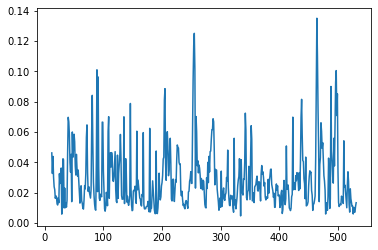

In [77]:
plt.plot(data2["frame"], data2["whitecap_fraction"])

In [78]:
frames_path = glob.glob(os.path.join(input_path, '*JPG'))
data = pd.DataFrame()
for fpath in frames_path:
    # read in the frame
    frame = cv2.imread(fpath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # get the region of interest
    frame = roi_region(0, 200, 1920, 600, frame)
    # do the thresholding
    thresh = Triangle_Threshold(frame)
    ret, image_thresh = cv2.threshold(frame, thresh, 255, cv2.THRESH_BINARY)
    
    
    wcf1 = frame[frame > (thresh - 5)].size / frame.size
    wcf2 = frame[frame > (thresh - 4)].size / frame.size
    wcf3 = frame[frame > (thresh - 3)].size / frame.size
    wcf4 = frame[frame > (thresh - 2)].size / frame.size
    wcf5 = frame[frame > (thresh - 1)].size / frame.size
    wcf6 = frame[frame > (thresh)].size / frame.size
    wcf7 = frame[frame > (thresh + 1)].size / frame.size
    wcf8 = frame[frame > (thresh + 2)].size / frame.size
    wcf9 = frame[frame > (thresh + 3)].size / frame.size
    wcf10 = frame[frame > (thresh + 4)].size / frame.size
    wcf11 = frame[frame > (thresh + 5)].size / frame.size
    
    data = data.append(pd.DataFrame({'frame' : [int(fpath[-9:-4])],'wcf1' : [wcf1], 
                                    'wcf2' : [wcf2],'wcf3' : [wcf3],'wcf4' : [wcf4],
                                    'wcf5' : [wcf5],'wcf6' : [wcf6],'wcf7' : [wcf7],
                                    'wcf8' : [wcf8],'wcf9' : [wcf9],'wcf10' : [wcf10],
                                    'wcf11' : [wcf11]}), ignore_index=True)
    

In [81]:
data2 = data.loc[(data['wcf1']<0.4) & (data['wcf2']<0.4) & (data['wcf3']<0.4)
                & (data['wcf4']<0.4) & (data['wcf5']<0.4) & (data['wcf6']<0.4)
                & (data['wcf7']<0.4) & (data['wcf8']<0.4) & (data['wcf9']<0.4)
                & (data['wcf10']<0.4) & (data['wcf11']<0.4)]

In [91]:
data2 = data2.reset_index()

In [92]:
data2

,index,frame,wcf1,wcf2,wcf3,wcf4,wcf5,wcf6,wcf7,wcf8,wcf9,wcf10,wcf11
0,11,12,0.051767,0.050471,0.049298,0.048148,0.047117,0.046172,0.045304,0.044463,0.043661,0.042885,0.042103
1,12,13,0.037956,0.036571,0.035391,0.034353,0.033390,0.032588,0.031921,0.031303,0.030772,0.030240,0.029798
2,13,14,0.049898,0.048471,0.047148,0.045970,0.044871,0.043853,0.042918,0.042043,0.041224,0.040405,0.039632
3,14,15,0.036497,0.035022,0.033690,0.032477,0.031366,0.030275,0.029380,0.028536,0.027684,0.026920,0.026169
4,15,16,0.028836,0.027728,0.026601,0.025635,0.024728,0.023845,0.023069,0.022305,0.021583,0.020881,0.020240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,526,527,0.014195,0.013098,0.012168,0.011409,0.010753,0.010165,0.009668,0.009232,0.008858,0.008532,0.008251
509,527,528,0.010776,0.009771,0.008912,0.008174,0.007458,0.006881,0.006419,0.006006,0.005648,0.005373,0.005102
510,528,529,0.010823,0.009804,0.008880,0.008169,0.007633,0.007145,0.006746,0.006404,0.006114,0.005859,0.005631
511,529,530,0.015123,0.013964,0.012992,0.012178,0.011495,0.010936,0.010468,0.010060,0.009688,0.009347,0.009037


In [99]:
np.average(data2.iloc[:, 2])

0.0343844826185835

In [96]:
for i in range(11):
    print(i)

0
1
2
3
4
5
6
7
8
9
10


In [111]:
mean_data = pd.DataFrame()
for i in range(11):
    mean_data = mean_data.append(pd.DataFrame({'mean': [np.average(data2.iloc[:, i+2])]}),ignore_index=True)

In [112]:
mean_data

,mean
0,0.034384
1,0.033067
2,0.031901
3,0.030869
4,0.029945
5,0.029113
6,0.028395
7,0.027708
8,0.027077
9,0.026495


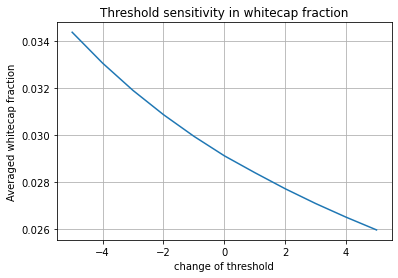

In [140]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-5, 5, num=11), mean_data)

props = {'title': 'Threshold sensitivity in whitecap fraction',
        'ylabel': 'Averaged whitecap fraction', # 坐标系-坐标轴-标签
        'xlabel':'change of threshold'} # 坐标系-坐标轴-标签 
ax.set(**props)

plt.grid()

fig.savefig('E:/my-deepwaves/figure2.png',dpi = 300, bbox_inches='tight')

In [118]:
mean_data.iloc[1]

mean    0.033067
Name: 1, dtype: float64

In [121]:
d_rate = []
for i in range(10):
    d_rate.append((mean_data.iloc[i] - mean_data.iloc[i + 1])/mean_data.iloc[i])

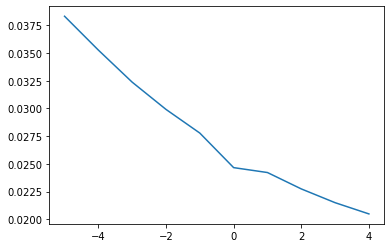

In [123]:
plt.plot(np.linspace(-5, 4, num=10), d_rate)

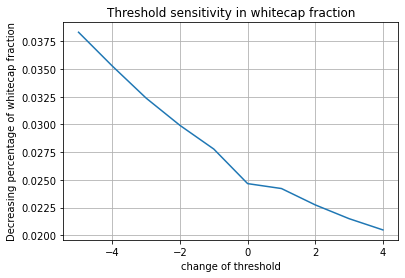

In [138]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-5, 4, num=10), d_rate)

props = {'title': 'Threshold sensitivity in whitecap fraction', #坐标系-标题
        'ylabel': 'Decreasing percentage of whitecap fraction', # 坐标系-坐标轴-标签
        'xlabel':'change of threshold'} # 坐标系-坐标轴-标签 
ax.set(**props)

plt.grid()

fig.savefig('E:/my-deepwaves/figure1.png',dpi = 300, bbox_inches='tight')

# DBSCAN sensitivity in Whitecaps

In [2]:
# ML
from sklearn.utils import parallel_backend
from sklearn.cluster import DBSCAN, OPTICS
import hdbscan
import miniball
import numpy.linalg as la

In [70]:
def cluster(img, eps, min_samples, backend="dbscan", nthreads=2,
            fit_kind="circle"):
    """
    Cluster group of pixels.

    Parameters:
    ----------
    img : np.ndarray
        Input image. Must be binary.
    eps : float
        Maximum distance allowed to form a cluster.
    min_samples : int
        Minimum number of samples to form a cluster.
    backend : str
        Which backend to use for clustering. Default is DBSCAN.
    fit_kind : str
        What type of geometry to fir to the clusters. Default is circle.

    Returns:
    -------
    df : pd.DataFrame
        A dataframe with the clustering results.
    """
    ipx, jpx = np.where(img)  # gets where img == 1
    X = np.vstack([ipx, jpx]).T

    if len(X) > min_samples:
        if backend.lower() == "optics":
            db = OPTICS(cluster_method="dbscan",
                        metric="euclidean",
                        eps=eps,
                        max_eps=eps,
                        min_samples=min_samples,
                        min_cluster_size=min_samples,
                        n_jobs=nthreads,
                        algorithm="ball_tree").fit(X)
            labels = db.labels_
        elif backend.lower() == "hdbscan":
            db = hdbscan.HDBSCAN(min_cluster_size=int(min_samples),
                                 metric="euclidean",
                                 allow_single_cluster=True,
                                 core_dist_n_jobs=nthreads)
            labels = db.fit_predict(X)
        elif backend.lower() == "dbscan":
            db = DBSCAN(eps=eps,
                        metric="euclidean",
                        min_samples=min_samples,
                        n_jobs=nthreads,
                        algorithm="ball_tree").fit(X)
            labels = db.labels_
        else:
            raise ValueError("Use either DBSCAN or OPTICS.")

        # to dataframe
        df = pd.DataFrame(X, columns=["j", "i"])
        df["cluster"] = labels
        df = df[df["cluster"] >= 0]
        # -1是噪声，其他的是不同的被标记了的cluster, 0, 1, 2, 3, 4, 5...

        # get centers and radii
        cluster = []
        i_center = []
        j_center = []
        n_pixels = []
        R1 = []
        R2 = []
        theta = []
        for cl, gdf in df.groupby("cluster"):
            # 对所有cluster的点，根据label进行了分组，cl是cluster的标签，gdf是每个cluster里面的pixel的坐标

            # fit a circle
            if fit_kind == "circle":
                c, r2 = miniball.get_bounding_ball(
                    gdf[["i", "j"]].values.astype(float))
                xc, yc = c
                r1 = np.sqrt(r2)
                r2 = r1  # these are for ellipses only
                t = 0  # these are for ellipses only
            elif fit_kind == "ellipse":
                try:
                    # compute the minmun bounding ellipse
                    A, c = mvee(gdf[["i", "j"]].values.astype(float))
                    # centroid
                    xc, yc = c
                    # radius, angle and eccentricity
                    r1, r2, t, _ = get_ellipse_parameters(A)
                except Exception:
                    # fall back to circle
                    c, r2 = miniball.get_bounding_ball(
                        gdf[["i", "j"]].values.astype(float))
                    xc, yc = c
                    r1 = np.sqrt(r2)
                    r2 = r1  # these are for ellipses only
                    t = 0  # these are for ellipses only
            else:
                raise ValueError("Can only fit data to circles or ellipses.")
            # append to output
            i_center.append(xc)
            j_center.append(yc)
            cluster.append(cl)
            n_pixels.append(len(gdf))
            R1.append(r1)
            R2.append(r2)
            theta.append(t)

        # to dataframe
        x = np.vstack([i_center, j_center, n_pixels,
                       R1, R2, theta,
                       cluster]).T
        columns = ["ic", "jc", "pixels", "ir", "jr", "theta_ij", "cluster"]
        df = pd.DataFrame(x, columns=columns)

        return df

    else:
        return pd.DataFrame()

In [71]:
def mvee(points, tol=0.001):
    """
    Finds the ellipse equation in center form (x-c).T * A * (x-c) = 1

    See:
    http://stackoverflow.com/questions/1768197/bounding-ellipse/1768440#1768440

    Parameters:
    ----------
    points : np.ndarray
        Input points. It is an array N*M with N number of samples and M number
        of features (dimensions). In 2D it;s N*2.
    tol : float
        Tolerance for the algorithm. Defaults to 0.0001.

    Returns:
    -------
    A : np.ndarray
        Array with the ellipse parameters.
    C : np.ndarray
        Array with the centers of the ellipse.
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol + 1.0
    u = np.ones(N) / N
    while err > tol:
        # assert u.sum() == 1 # invariant
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, la.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx] - d - 1.0) / ((d + 1) * (M[jdx] - 1.0))
        new_u = (1 - step_size) * u
        new_u[jdx] += step_size
        err = la.norm(new_u - u)
        u = new_u
    c = np.dot(u, points)
    A = la.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c)) / d
    return A, c

In [72]:
def get_ellipse_parameters(A):
    """
    Finds the ellipse paramters from A.

    See:
    http://stackoverflow.com/questions/1768197/bounding-ellipse/1768440#1768440

    Parameters:
    ----------
    A : np.ndarray
        Use mvee to get the correct array.

    Returns:
    -------
    a, b : float
        major and minor axis of the ellipse
    C : np.ndarray
        Array with the centers of the ellipse.
    """
    # compute SVD
    U, D, V = la.svd(A)

    # x, y radii.
    rx, ry = 1. / np.sqrt(D)

    # Major and minor semi-axis of the ellipse.
    dx, dy = 2 * rx, 2 * ry
    a, b = max(dx, dy), min(dx, dy)

    # eccentricity
    e = np.sqrt(a ** 2 - b ** 2) / a

    arcsin = -1. * np.rad2deg(np.arcsin(V[0][0]))
    arccos = np.rad2deg(np.arccos(V[0][1]))

    # orientation angle (with respect to the x axis counterclockwise).
    theta = arccos if arcsin > 0. else -1. * arccos

    return a / 2, b / 2, theta, e

In [78]:
input_path = "E:/GoPro_deep/image/GH020008/"
frames_path = glob.glob(os.path.join(input_path, '*JPG'))
img = cv2.imread(frames_path[13])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get the region of interest
img = roi_region(0, 200, 1920, 600, img)
# do the thresholding
thresh = Triangle_Threshold(img)
ret, image_thresh = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)

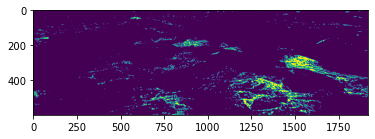

In [9]:
plt.imshow(image_thresh)

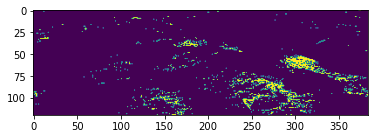

In [16]:
img_resize = cv2.resize(image_thresh, (0, 0), fx = 0.2, fy = 0.2)
plt.imshow(img_resize)

In [33]:
?cv2.resize

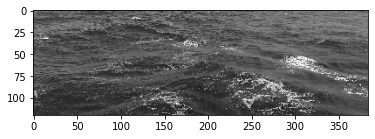

In [34]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_resize_c = cv2.resize(img, (0, 0), fx = 0.2, fy = 0.2)
plt.imshow(img_resize_c)

In [142]:
df = cluster(img_resize, 10, 15, backend="dbscan", nthreads=2,
            fit_kind="ellipse")

In [143]:
df

,ic,jc,pixels,ir,jr,theta_ij,cluster
0,115.301536,10.422565,15.0,8.716539,2.396032,161.410472,0.0
1,12.468116,26.544512,28.0,12.266571,7.066306,136.179855,1.0
2,175.567312,43.013216,129.0,23.860289,21.662067,-41.119893,2.0
3,221.660284,44.328124,41.0,18.251250,7.409696,1.265935,3.0
4,330.706872,70.525223,577.0,68.882988,15.575633,19.719990,4.0
5,103.682103,64.149259,24.0,15.236003,9.648124,57.473038,5.0
6,155.323555,61.343302,23.0,13.598656,8.136707,-13.135811,6.0
7,270.171860,94.087276,773.0,63.315102,25.492281,8.340196,7.0
8,202.605902,81.893686,16.0,9.883130,7.666968,119.002193,8.0
9,149.342106,104.041422,230.0,39.919439,16.113611,10.003833,9.0


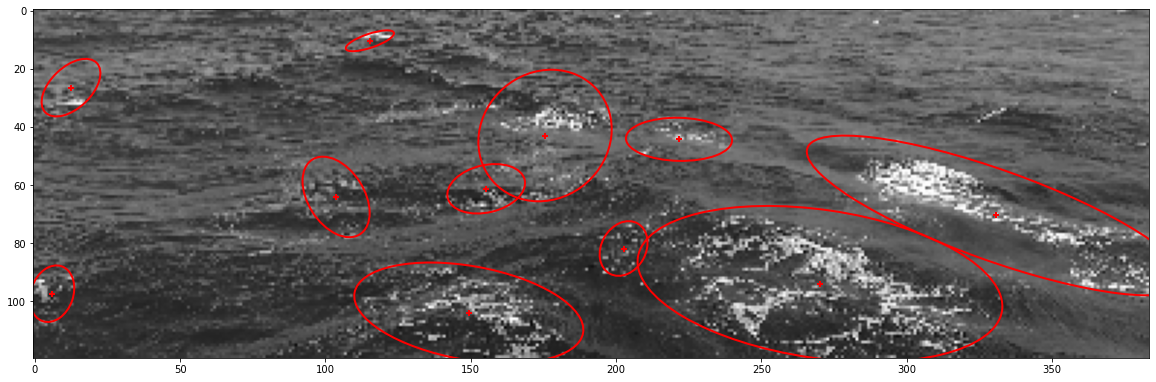

In [144]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img_resize_c)
ax.scatter(df["ic"], df["jc"], marker="+",
                       linewidth=2, alpha=1, color='red')
for i, row in df.iterrows():
    c = patches.Ellipse((row["ic"], row["jc"]),
                                        row["ir"] * 2, row["jr"] * 2,
                                        angle=row["theta_ij"],
                                        facecolor="none",
                                        edgecolor = 'red',
                                        linewidth=2)
    ax.add_artist(c)
fig.savefig('E:/my-deepwaves/figure3.png',dpi = 300, bbox_inches='tight')

In [84]:
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

cv2.imwrite('E:/my-deepwaves/figure4.png',img)

True

C:\Users\YANG~1.XIN\AppData\Local\Temp/ipykernel_3388/931431749.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


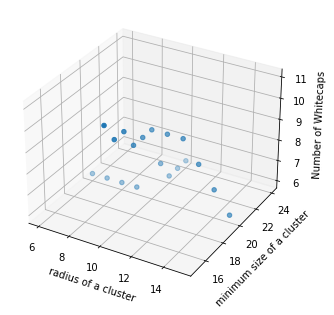

In [3]:
from mpl_toolkits.mplot3d import Axes3D

x = np.array([10, 11, 12, 13, 14, 15, 9, 8, 7, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10])
y = np.array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 16, 17, 18, 19, 21, 22, 23, 24])
z = np.array([9, 9, 9, 8, 7, 6, 6, 6, 6, 6, 11, 10, 10, 9, 9, 7, 6, 6, 6])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)

ax.set_zlabel('Number of Whitecaps')
ax.set_ylabel('minimum size of a cluster')
ax.set_xlabel('radius of a cluster')
plt.show()

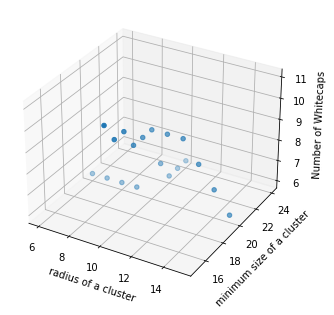

In [152]:
from mpl_toolkits.mplot3d import Axes3D

x = np.array([10, 11, 12, 13, 14, 15, 9, 8, 7, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10])
y = np.array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 16, 17, 18, 19, 21, 22, 23, 24])
z = np.array([9, 9, 9, 8, 7, 6, 6, 6, 6, 6, 11, 10, 10, 9, 9, 7, 6, 6, 6])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)

ax.set_zlabel('Number of Whitecaps')
ax.set_ylabel('minimum size of a cluster')
ax.set_xlabel('radius of a cluster')
plt.show()

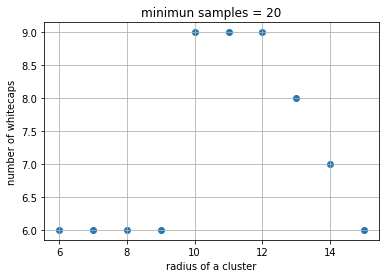

In [154]:
x = np.array([10, 11, 12, 13, 14, 15, 9, 8, 7, 6])
y = np.array([9, 9, 9, 8, 7, 6, 6, 6, 6, 6])

fig, ax = plt.subplots()

ax.scatter(x, y)

props = {'title': 'minimun samples = 20', #坐标系-标题
        'ylabel': 'number of whitecaps', # 坐标系-坐标轴-标签
        'xlabel':'radius of a cluster'} # 坐标系-坐标轴-标签 
ax.set(**props)

plt.grid()

fig.savefig('E:/my-deepwaves/figure5.png',dpi = 300, bbox_inches='tight')

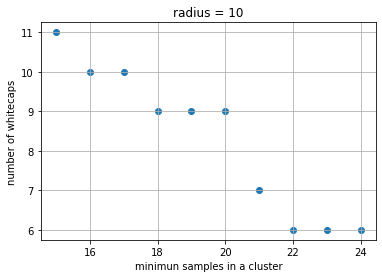

In [155]:
x = np.array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
y = np.array([11, 10, 10, 9, 9, 9, 7, 6, 6, 6])

fig, ax = plt.subplots()

ax.scatter(x, y)

props = {'title': 'radius = 10', #坐标系-标题
        'ylabel': 'number of whitecaps', # 坐标系-坐标轴-标签
        'xlabel':'minimun samples in a cluster'} # 坐标系-坐标轴-标签 
ax.set(**props)

plt.grid()

fig.savefig('E:/my-deepwaves/figure6.png',dpi = 300, bbox_inches='tight')

# Improve thresholding func

In [6]:
input_path = "E:/GoPro_deep/image/GH020008/"

In [8]:
frames_path = glob.glob(os.path.join(input_path, '*JPG'))

In [23]:
img = cv2.imread(frames_path[13])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img], [0], None, [256], [0, 256])


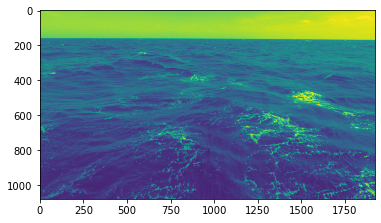

In [31]:
plt.imshow(img)

In [41]:
img.shape

(1080, 1920)

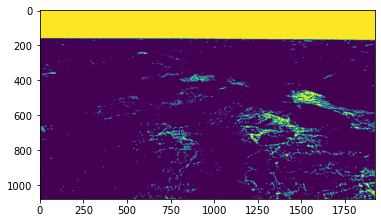

In [34]:
ret, image_thresh = cv2.threshold(img, 150, 255,
                                      cv2.THRESH_BINARY)
plt.imshow(image_thresh)

In [30]:
hist

array([[0.0000e+00],
       [0.0000e+00],
       [2.0000e+00],
       [4.0000e+00],
       [1.1000e+01],
       [2.0000e+01],
       [2.8000e+01],
       [3.5000e+01],
       [4.6000e+01],
       [6.8000e+01],
       [7.8000e+01],
       [1.0500e+02],
       [1.2900e+02],
       [1.7300e+02],
       [2.3000e+02],
       [3.0200e+02],
       [3.7200e+02],
       [3.9400e+02],
       [5.3900e+02],
       [6.5300e+02],
       [7.1800e+02],
       [8.9900e+02],
       [1.0570e+03],
       [1.2210e+03],
       [1.5390e+03],
       [1.9400e+03],
       [3.0830e+03],
       [4.0390e+03],
       [7.4500e+03],
       [1.0669e+04],
       [1.4457e+04],
       [1.6542e+04],
       [2.3804e+04],
       [2.4754e+04],
       [2.8923e+04],
       [3.0336e+04],
       [3.0605e+04],
       [2.8700e+04],
       [2.9384e+04],
       [2.6063e+04],
       [2.5456e+04],
       [2.3063e+04],
       [2.4090e+04],
       [2.3172e+04],
       [2.2986e+04],
       [2.2842e+04],
       [2.2696e+04],
       [2.161

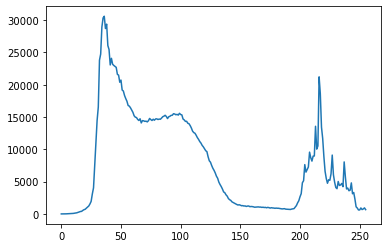

In [40]:
plt.plot(hist)

(array([0.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.1000e+01,
        2.0000e+01, 2.8000e+01, 3.5000e+01, 4.6000e+01, 6.8000e+01,
        7.8000e+01, 1.0500e+02, 1.2900e+02, 1.7300e+02, 2.3000e+02,
        3.0200e+02, 3.7200e+02, 3.9400e+02, 5.3900e+02, 6.5300e+02,
        7.1800e+02, 8.9900e+02, 1.0570e+03, 1.2210e+03, 1.5390e+03,
        1.9400e+03, 3.0830e+03, 4.0390e+03, 7.4500e+03, 1.0669e+04,
        1.4457e+04, 1.6542e+04, 2.3804e+04, 2.4754e+04, 2.8923e+04,
        3.0336e+04, 3.0605e+04, 2.8700e+04, 2.9384e+04, 2.6063e+04,
        2.5456e+04, 2.3063e+04, 2.4090e+04, 2.3172e+04, 2.2986e+04,
        2.2842e+04, 2.2696e+04, 2.1611e+04, 2.1488e+04, 2.0388e+04,
        2.0721e+04, 1.9178e+04, 1.9026e+04, 1.8334e+04, 1.7857e+04,
        1.7444e+04, 1.6789e+04, 1.6687e+04, 1.6419e+04, 1.6058e+04,
        1.5729e+04, 1.5202e+04, 1.4981e+04, 1.4919e+04, 1.4633e+04,
        1.4464e+04, 1.4729e+04, 1.4087e+04, 1.4446e+04, 1.4413e+04,
        1.4325e+04, 1.4364e+04, 1.4247e+04, 1.44

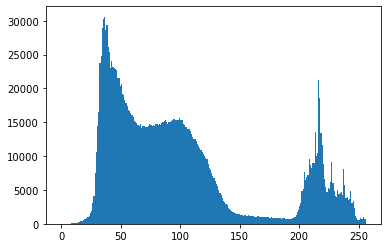

In [29]:
plt.hist(img.ravel(), 256, [0, 256]) # ravel 可以将多维拉伸为一维且不产生源数据的副本

In [22]:
?cv2.calcHist

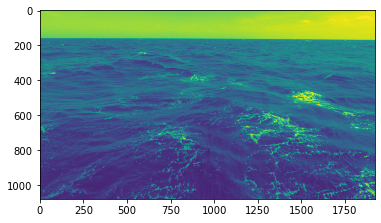

In [19]:
plt.imshow(img)

In [19]:
frames_path = glob(os.path.join(input_path, '*JPG'))
for fpath in frames_path:
    # read in the frame
    frame = cv2.imread(fpath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    

['E:/GoPro_deep/image/GH020008\\img00001.JPG',
 'E:/GoPro_deep/image/GH020008\\img00002.JPG',
 'E:/GoPro_deep/image/GH020008\\img00003.JPG',
 'E:/GoPro_deep/image/GH020008\\img00004.JPG',
 'E:/GoPro_deep/image/GH020008\\img00005.JPG',
 'E:/GoPro_deep/image/GH020008\\img00006.JPG',
 'E:/GoPro_deep/image/GH020008\\img00007.JPG',
 'E:/GoPro_deep/image/GH020008\\img00008.JPG',
 'E:/GoPro_deep/image/GH020008\\img00009.JPG',
 'E:/GoPro_deep/image/GH020008\\img00010.JPG',
 'E:/GoPro_deep/image/GH020008\\img00011.JPG',
 'E:/GoPro_deep/image/GH020008\\img00012.JPG',
 'E:/GoPro_deep/image/GH020008\\img00013.JPG',
 'E:/GoPro_deep/image/GH020008\\img00014.JPG',
 'E:/GoPro_deep/image/GH020008\\img00015.JPG',
 'E:/GoPro_deep/image/GH020008\\img00016.JPG',
 'E:/GoPro_deep/image/GH020008\\img00017.JPG',
 'E:/GoPro_deep/image/GH020008\\img00018.JPG',
 'E:/GoPro_deep/image/GH020008\\img00019.JPG',
 'E:/GoPro_deep/image/GH020008\\img00020.JPG',
 'E:/GoPro_deep/image/GH020008\\img00021.JPG',
 'E:/GoPro_de

In [ ]:
fraction_list = []  # list store the whitecaps fraction
order = []  # store the names of the images corresponding to the fraction
for p in pic_list:

    image_ini = cv2.imread(pic_path + "/" + p)

    image_gray = cv2.cvtColor(image_ini, cv2.COLOR_BGR2GRAY)
    index = np.argwhere(image_gray > 0)
    ymax = max(index[:, 0])
    xmax = max(index[:, 1])
    img = unevenLightCompensate(image_ini[crop_y_min:crop_y_max, crop_x_min:crop_x_max], 100)
    image_crop = img

    #image_crop = image_gray[500:ymax, 100:500]

    threshold = Triangle_Threshold(image_crop)


    if (threshold + 30) > 255:
        threshold = 255 - 30

    ret, image_thresh = cv2.threshold(image_crop, 80, 255,
                                      cv2.THRESH_BINARY)  #白浪比太小了，调低看看
    #ret, image_thresh = cv2.threshold(image_crop, threshold+5, 255, cv2.THRESH_BINARY)

    # Do Some Crop!!!!!

    cv2.imwrite(new_path + "/" + "wc_" + p, image_thresh)

    # Calculate the whitecaps fraction
    area = image_crop[image_crop > 0].size
    whitecaps = image_thresh[image_thresh > 0].size
    fraction = whitecaps / area
    fraction_list.append(fraction)
    order.append(p)

    # write the whitecaps fraction into a csv file
    file_csv = codecs.open(new_path + "/" + "ATS_wf.csv", "w+", "utf-8")
    writer = csv.writer(file_csv, delimiter=' ', quotechar=' ')
    for i in range(np.size(fraction_list)):
        row = [fraction_list[i]]
        writer.writerow(row)
    file_csv.close()

## Image Pyramid

In [14]:
import cv2
import glob
import os
import matplotlib.pyplot as plt

In [7]:
filepath = 'E:/GoPro_deep/image/GH020008/'

In [11]:
framepath = glob.glob(os.path.join(filepath, '*JPG'))

In [12]:
img = cv2.imread(framepath[20])

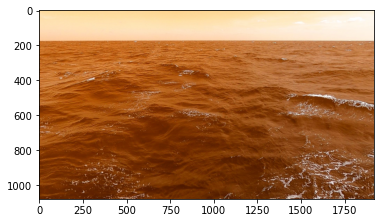

In [15]:
plt.imshow(img)

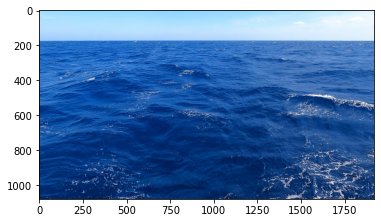

In [16]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [17]:
g0 = img
g1 = cv2.pyrDown(g0)
laplacian0 = g0 - cv2.pyrUp(g1)
origin = laplacian0 + cv2.pyrUp(g1)

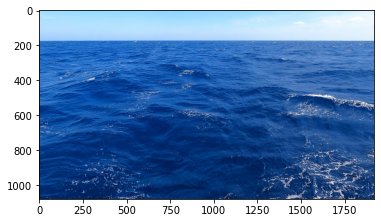

In [22]:
plt.imshow(g0)

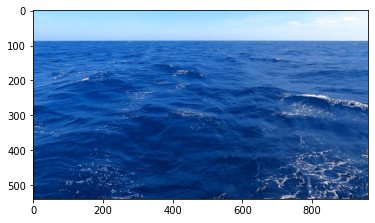

In [19]:
plt.imshow(g1)

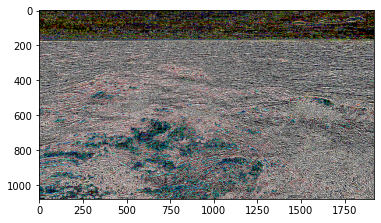

In [20]:
plt.imshow(laplacian0)

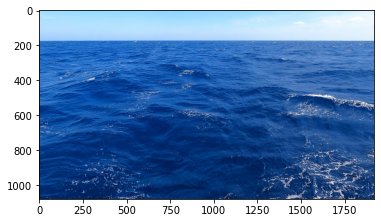

In [21]:
plt.imshow(origin)